###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 parts of this notebook are from [this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/The%20Finite-Difference%20Method/fd_ac1d.ipynb) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Lion Krischer ([@krischer](https://github.com/krischer)) and Taufiqurrahman ([@git-taufiqurrahman](https://github.com/git-taufiqurrahman)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/),  additional modifications by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# FD stability and dispersion

In the [last lesson](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/03_Intro_finite_differences/2_fd_ac1d.ipynb) we developed a 1D acoustic FD modelling code. For the given modelling parameters, the code worked flawlessly and delivered modelled seismograms, which are in good agreement with the analytical solution. In this lesson we want to investigate how to choose optimum time steps dt and spatial grid point distances dx, to get stable and accurate FD modelling results. We start, by revisiting a simplified version of our 1D acoustic FD modelling code ...

In [2]:
# Import Libraries 
# ----------------
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definition of modelling parameters
# ----------------------------------
xmax = 500 # maximum spatial extension of the 1D model (m)
dx   = 0.5 # grid point distance in x-direction

tmax = 1.001   # maximum recording time of the seismogram (s)
dt   = 0.0010  # time step

vp0  = 333.   # P-wave speed in medium (m/s)

# acquisition geometry
xr = 365.0 # receiver position (m)
xsrc = 249.5 # source position (m)

f0   = 25. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

## Comparison of numerical with analytical solution

In the function below we solve the homogeneous 1D acoustic wave equation by the 3-point spatial/temporal difference operator and compare the numerical results with the analytical solution. To play a little bit more with the modelling parameters, I restricted the input parameters to dt and dx. The number of spatial grid points and time steps, as well as the discrete source and receiver positions are estimated within this function.

In [4]:
# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
def FD_1D_acoustic(dt,dx,spec):
        
    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)
        
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)
    
    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    #src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))
    
    # 2nd derivative of a Gaussian
    src = (1.0 - 2.0*(np.pi**2)*(f0**2)*((time-t0)**2)) * np.exp(-(np.pi**2)*(f0**2)*((time-t0)**2))

    # Analytical solution
    # -------------------
    G    = time * 0.

    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinate in x-direction

    for it in range(nt): # Calculate Green's function (Heaviside function)
        if (time[it] - np.abs(x[ir] - x[isrc]) / vp0) >= 0:
            G[it] = 1. / (2 * vp0)
    Gc   = np.convolve(G, src * dt)
    Gc   = Gc[0:nt]
    lim  = Gc.max() # get limit value from the maximum amplitude
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros(nx) # p at time n (now)
    pold = np.zeros(nx) # p at time n-1 (past)
    pnew = np.zeros(nx) # p at time n+1 (present)
    d2px = np.zeros(nx) # 2nd space derivative of p

    # Initialize model (assume homogeneous model)
    # -------------------------------------------
    vp    = np.zeros(nx)
    vp    = vp + vp0       # initialize wave velocity in model

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        for i in range(1, nx - 1):
            d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp ** 2 * dt ** 2 * d2px

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc] = pnew[isrc] + src[it] / dx * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir]   
        
    # Compare FD Seismogram with analytical solution
    # ---------------------------------------------- 
    # Define figure size
    fig1 = plt.figure(figsize=(12, 5))
    plt.plot(time, seis, 'b-',lw=3,label="FD solution") # plot FD seismogram
    Analy_seis = plt.plot(time,Gc,'r--',lw=3,label="Analytical solution") # plot analytical solution
    plt.xlim(time[0], time[-1])
    plt.ylim(-lim, lim)
    plt.title('Seismogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    
    # Plot amplitude spectrum of seismogram
    if(spec==True):
        fig2 = plt.figure(figsize=(12, 5))
        spec = np.fft.fft(src) # source time function in frequency domain
        freq = np.fft.fftfreq(spec.size, d = dt) # time domain to frequency domain
        plt.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
        plt.xlim(0, 70) # only display frequency from 0 to 250 Hz
        plt.title('Amplitude Spectrum (Source Wavelet)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('|FFT(src)|')
        
    plt.show()            

nx =  1000
nt =  1000


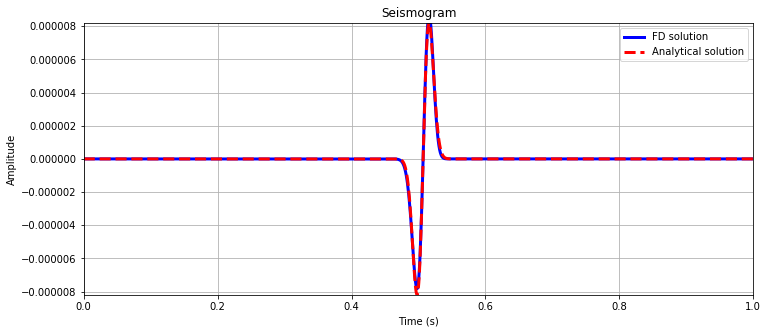

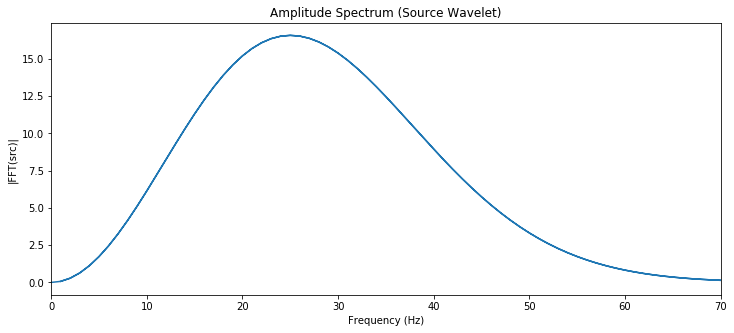

In [5]:
dx   = 0.5 # grid point distance in x-direction
dt   = 0.0010  # time step
FD_1D_acoustic(dt,dx,True)

This is the same result, we achieved in the last lesson. Now, you might get the smart idea to save some computation time by increasing the timestep dt. Let's try it ... 

nx =  1000
nt =  664


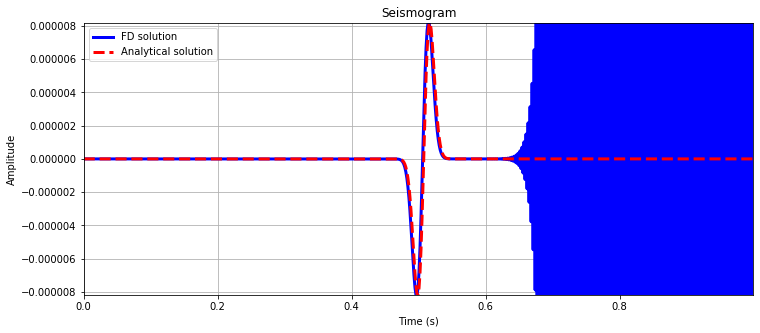

In [6]:
dx   = 0.5 # grid point distance in x-direction
#dt   = 0.0010  # old time step
dt   = 0.0015053  # time step
FD_1D_acoustic(dt,dx,False)

Oops, maybe this idea was not so smart at all, because the modelling becomes **unstable**. Instead of increasing the time step dt, we could try to increase the spatial discretization dx to save computation time ...

nx =  250
nt =  1000


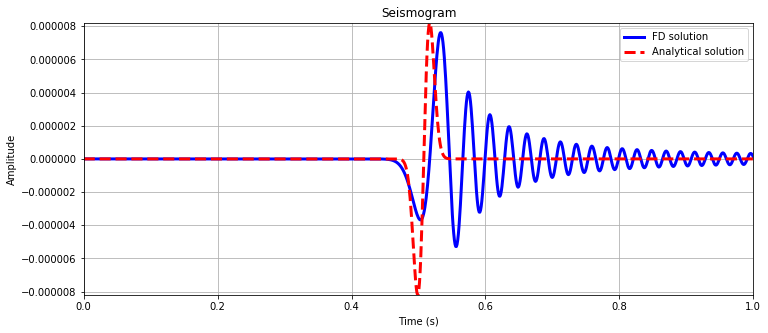

In [7]:
# dx   = 0.5 # old grid point distance in x-direction
dx   = 2.0 # new grid point distance in x-direction
dt   = 0.0010  # time step
FD_1D_acoustic(dt,dx,False)

Hmm, the accurracy of the FD modelling result compared to the analytical solution is clearly deterioated, when the spatial grid point $dx$ is increased. And why does the P-body wave becomes dispersive? More generally, how do I choose $dx$ and $dt$ without using a trial-and-error approach, which requires a lot of computation time, especially when considering 3D modelling. To understand the underlying problems, we will investigate the stability and numerical dispersion of the FD method in the next two sections.

## Stability of 1D acoustic wave equation finite difference approximation

To analyse the stability of the finite difference approximation of the 1D acoustic wave equation:

\begin{equation}
 \frac{p_{j}^{n+1} - 2 p_{j}^n + p_{j}^{n-1}}{\mathrm{d}t^2} \ = \ vp_{j}^2 \frac{p_{j+1}^{n} - 2 p_{j}^n + p_{j-1}^{n}}{\mathrm{d}x^2},
\end{equation}

we use an approach introduced by the famous mathematician and pioneer of computational sciences [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann). For the **von Neumann Analysis**, we assume harmonic plane wave solutions for the pressure wavefield like:

\begin{equation}
p = exp(i(kx-\omega t)),\nonumber
\end{equation}

with $i^2=-1$, the wavenumber $k$ and circular frequency $\omega$. Using the discrete 
spatial coordinates:

$x_j = j dx,$

and times 

$t_n = n dt.$

We can calculate discrete plane wave solutions at the discrete locations and times in eq. (1), for example at grid point j and time n:  

\begin{equation}
p_j^n = exp(i(kjdx-\omega n dt)),\nonumber
\end{equation}

or at grid point j and time n+1:

\begin{align}
p_j^{n+1} &= exp(i(kjdx-\omega (n+1) dt))\nonumber\\
&= exp(-i\omega dt)\; exp(i(kjdx-\omega n dt))\nonumber\\
&= exp(-i\omega dt)\; p_j^n,\nonumber\\
\end{align}

or at the grid point j and time n-1:

\begin{align}
p_j^{n-1} &= exp(i(kjdx-\omega (n-1) dt))\nonumber\\
&= exp(i\omega dt)\; exp(i(kjdx-\omega n dt))\nonumber\\
&= exp(i\omega dt)\; p_j^n.\nonumber\\
\end{align}

Similar approximations can be estimated for time n at the spatial grid points j+1:

\begin{align}
p_{j+1}^{n} &= exp(i(k(j+1)dx-\omega n dt))\nonumber\\
&= exp(ik dx)\; exp(i(kjdx-\omega n dt))\nonumber\\
&= exp(ik dx)\; p_j^n,\nonumber\\
\end{align}

and a grid point j-1:

\begin{align}
p_{j-1}^{n} &= exp(i(k(j-1)dx-\omega n dt))\nonumber\\
&= exp(-ik dx)\; exp(i(kjdx-\omega n dt))\nonumber\\
&= exp(-ik dx)\; p_j^n.\nonumber\\
\end{align}

Inserting the discrete pressure wavefield solutions $p_j^{n+1}$, $p_j^{n-1}$, $p_{j+1}^{n}$ and $p_{j-1}^{n}$ in eq. (1), we get after some minor rearrangement:

\begin{equation}
exp(-i\omega dt)p_j^n - 2 p_j^n + exp(i\omega dt)p_j^n = vp_j^2 \frac{dt^2}{dx^2}\biggl(exp(-ik dx)p_j^n - 2 p_j^n + exp(ik dx)p_j^n\biggr).\nonumber
\end{equation}

Assuming that $p_j^n \ne 0$, we can divide the RHS and LHS by $p_j^n$

\begin{equation}
exp(-i\omega dt) - 2 + exp(i\omega dt) = vp_j^2 \frac{dt^2}{dx^2}\biggl(exp(-ik dx) - 2 + exp(ik dx)\biggr).\nonumber
\end{equation}

By further dividing RHS and LHS by 2, we get:

\begin{equation}
\frac{exp(i\omega dt) + exp(-i\omega dt)}{2} - 1 = vp_j^2 \frac{dt^2}{dx^2}\biggl(\frac{exp(ik dx) + exp(-ik dx)}{2} - 1\biggr).\nonumber
\end{equation}

Using the definition 

\begin{equation}
\cos(x) = \frac{exp(ix) + exp(-ix)}{2},\nonumber
\end{equation}

we can simplify this expression to:

\begin{equation}
cos(\omega dt) - 1 = vp_j^2 \frac{dt^2}{dx^2}\biggl(cos(k dx) - 1\biggr).\nonumber
\end{equation}

After some further rearrangements and division of both sides by 2, leads to:

\begin{equation}
\frac{1 - cos(\omega dt)}{2} = vp_j^2 \frac{dt^2}{dx^2}\biggl(\frac{1 - cos(k dx)}{2}\biggr).\nonumber
\end{equation}

With the relation 

\begin{equation}
sin^2\biggl(\frac{x}{2}\biggr) = \frac{1-cos(x)}{2}, \nonumber
\end{equation}

we get 

\begin{equation}
sin^2\biggl(\frac{\omega dt}{2}\biggr) = vp_j^2 \frac{dt^2}{dx^2}\biggl(sin^2\biggl(\frac{k dx}{2}\biggr)\biggr).\nonumber
\end{equation}

Taking the square root of both sides finally leads to 

\begin{equation}
sin\frac{\omega dt}{2} = vp_j \frac{dt}{dx}\biggl(sin\frac{k dx}{2}\biggr).
\end{equation}

This result is quite interesting. Notice, that the amplitude of the sine functions $sin(x)$ on the LHS and RHS vary between -1 and 1. However, if the factor on the RHS

\begin{equation}
\epsilon = vp_j \frac{dt}{dx} \nonumber
\end{equation}

is larger 1 ($\epsilon>1$), you get only complex solutions. 

Consequently, the numerical scheme becomes unstable. Therefore, the criterion

\begin{equation}
\epsilon = vp_j \frac{dt}{dx} \le 1 \nonumber
\end{equation}

has to be satisfied. This very important stability criterion was first described by the german-american mathematicians Richard Courant, Kurt Friedrichs and Hans Lewy in [this paper](https://gdz.sub.uni-goettingen.de/id/PPN235181684_0100?tify={%22pages%22:[36],%22view%22:%22thumbnails%22}) from 1928. The **Courant-Friedrichs-Lewy criterion** or in short **CFL-criterion**, can also be rearranged to the time step dt, assuming that we have defined a spatial grid point distance dx:

\begin{equation}
dt  \le \frac{dx}{vp_j}. \nonumber
\end{equation}

This criterion is only correct for the FD solution of the 1D acoustic wave equation using the 3-point spatial/temporal FD operators and an explicit time-stepping scheme (eq.(1)).

More generally, we can write the Courant criterion as 

\begin{equation}
dt  \le \frac{dx}{\zeta vp_j}, \nonumber
\end{equation}

where the factor $\zeta$ depends on the used FD operator, dimension of the problem (1D, 2D, 3D) and the overall algorithm. Even though the CFL criterion strictly depends on the P-wave velocity at a specific grid point, in most cases the maximum velocity $v_{max}$ in the medium is used to estimate a constant time step $dt$ for the whole FD modelling run:

\begin{equation}
dt  \le \frac{dx}{\zeta v_{max}}, \nonumber
\end{equation}

where $v_{max}$ is the maximum P-wave velocity in the acoustic case or the maximum S-wave velocity for the SH-problem. While the fulfillment of the CFL criterion leads to a stable simulation, it does not guarantee accurate modelling results. 

The CFL criterion allows us to estimate an appropriate time step dt based on the maximum velocity in the model and the spatial grid point distance. But how do we choose the spatial gridpoint distance dx?

##### Exercise

Let 's investigate the statement, that equation (2) delivers only complex solutions if $\epsilon>1$. Try to find solutions to the following simple problem 

\begin{equation}
\sin(x) = 2 \nonumber
\end{equation}

**Hint**

Use Eulers identity $e^{iy} = cos(y) + i sin(y)$

## Numerical grid dispersion

In the modelling examples at the beginning of this Jupyter notebook, we have seen that the modelled wavefield can become subject to dispersion, when choosing a too large spatial grid point distance. The result of the von Neumann analysis can also explain this behaviour. Starting from eq. (2)

\begin{equation}
sin\frac{\omega dt}{2} = \epsilon\; sin\frac{k dx}{2}, \nonumber
\end{equation}

we apply the $arcsin$ to both sides

\begin{equation}
\frac{\omega dt}{2} = arcsin\biggl(\epsilon\; sin\frac{k dx}{2} \biggr)\nonumber
\end{equation}

and multiply the result by $\frac{2}{dt}$, we get

\begin{equation}
\omega = \frac{2}{dt}arcsin\biggl(\epsilon\; sin\frac{k dx}{2}\biggr)\nonumber
\end{equation}

Inserting this $\omega-k$ dependence into the definition of the phase velocity 

\begin{equation}
v_{phase} = \frac{\omega}{k},\nonumber
\end{equation}

leads to 

\begin{equation}
v_{phase} = \frac{2}{k dt}arcsin\biggl(\epsilon\; sin\frac{k dx}{2}\biggr).\nonumber
\end{equation}

As you can see, the phase velocity of the numerical FD solution is a function of the wavenumber k. Therefore, it can be subject to dispersion. To investigate this problem in more detail, we rewrite the phase velocity.

With the wavenumber $k=\frac{2 \pi}{\lambda}$, where $\lambda$ denotes the wavelength, we get:

\begin{equation}
v_{phase} = \frac{\lambda}{\pi dt}arcsin\biggl(\epsilon\; sin\frac{\pi dx}{\lambda}\biggr).\nonumber
\end{equation}

From the definition of $\epsilon = vp_0 \frac{dt}{dx}$, we can replace $dt$ by $dt = \frac{\epsilon dx}{vp_0}$ in the phase velocity:

\begin{equation}
v_{phase} = \frac{\lambda vp_0}{\pi \epsilon dx}arcsin\biggl(\epsilon\; sin\frac{\pi dx}{\lambda}\biggr).\nonumber
\end{equation}

Introducing the **number of grid points per wavelength** $N_\lambda = \frac{\lambda}{dx}$, we finally get:

\begin{equation}
v_{phase} = \frac{N_\lambda vp_0}{\pi \epsilon}arcsin\biggl(\epsilon\; sin\frac{\pi }{N_\lambda}\biggr).\nonumber
\end{equation}

Let's plot this result for $N_\lambda$ between 2 and 12, the homogeneous P-wave velocity $vp0\;=\;333\;m/s$, and $\epsilon$ values form 0.7 to 1.0 ...

In [8]:
Nwave = np.arange(2,12,0.25) # numbers per wavelength
vp0 = 333.0 # P-wave velocity (m/s)

def dispersion_1D(eps):
    
    vp_phase = (vp0*Nwave/(np.pi*eps)) * np.arcsin(eps*np.sin(np.pi/Nwave)) 
    
    return vp_phase

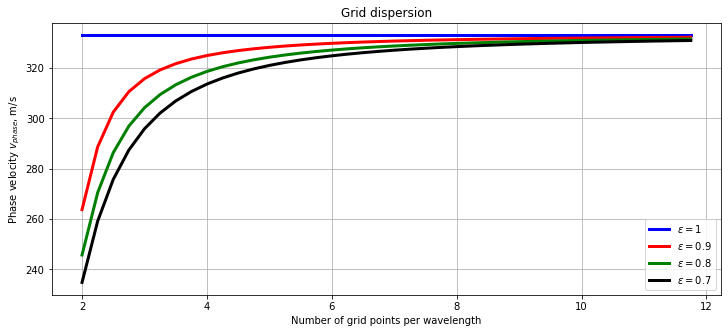

In [9]:
vp_eps_1 = dispersion_1D(1.0)
vp_eps_2 = dispersion_1D(0.9)
vp_eps_3 = dispersion_1D(0.8)
vp_eps_4 = dispersion_1D(0.7)

rcParams['figure.figsize'] = 12, 5
plt.plot(Nwave, vp_eps_1, 'b-',lw=3,label=r"$\epsilon=1$")
plt.plot(Nwave, vp_eps_2, 'r-',lw=3,label=r"$\epsilon=0.9$") 
plt.plot(Nwave, vp_eps_3, 'g-',lw=3,label=r"$\epsilon=0.8$") 
plt.plot(Nwave, vp_eps_4, 'k-',lw=3,label=r"$\epsilon=0.7$") 
plt.title('Grid dispersion')
plt.xlabel('Number of grid points per wavelength')
plt.ylabel('Phase velocity $v_{phase}$, m/s')
plt.legend()
plt.grid()
plt.show() 

Notice, that no grid dispersion occurs in the case of $\epsilon=1$. Keep in mind though that this only true for the homogeneous medium. Realistic modelling problems have a variable P-wave velocity, so we have not a constant $\epsilon$ within the model.

For all values $\epsilon<1$, numerical dispersion can occur, if the sampling of the spatial model is too small, especially when using only the Nyquist criterion $N_\lambda = 2$. For the 1D acoustic wave equation, the dispersion is minimized for $N_\lambda$ values between 8-12.

More generally, we can define the **grid dispersion criterion** for the spatial gridpoint distance

\begin{equation}
dx \le \frac{\lambda_{min}}{N_\lambda} = \frac{v_{min}}{N_\lambda f_{max}},\nonumber
\end{equation}

where $N_\lambda$ depends on the used FD operator, numerical scheme and also wave type, $v_{min}$ is the minimum P- or S-wave velocity in the model and $f_{max}$ the maximum frequency of the source wavelet. 

Finally, let's apply the dispersion and stability criteria to our test problem in order to find optimum dt and dx values ...

dx =  0.444
epsilon =  1.0
dt =  0.0013333333333333333
nx =  1126
nt =  750


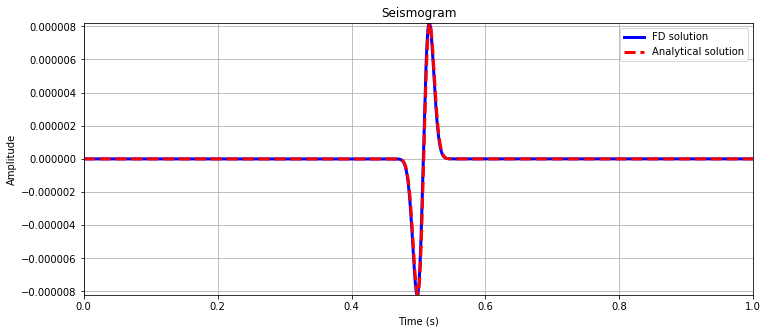

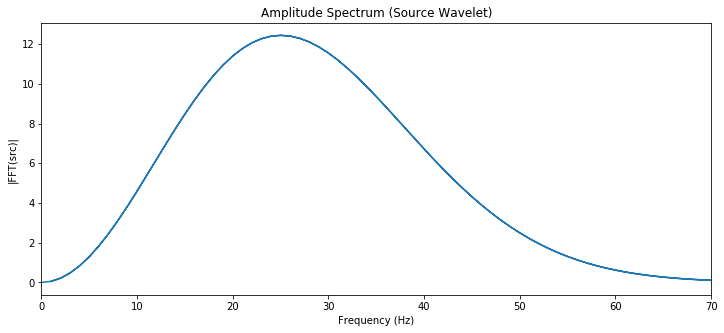

In [10]:
# calculate dx according to the grid dispersion criterion
Nlam = 15              # number of grid points per wavelength
fmax = 50.0            # maximum frequency of source wavelet ~ 2 * f0 (Hz)
dx = vp0 / (Nlam*fmax) # spatial gridpoint distance (m)
print('dx = ', dx)

# calculate dt according to the CFL criterion
dt = dx / vp0 # time step (s)

# check CFL criterion
epsilon = vp0 * dt / dx
print('epsilon = ', epsilon)
if(epsilon>1.0):
    print('Warning: CFL condition is violated!')
print('dt = ', dt)

FD_1D_acoustic(dt,dx,True)

## What we learned:

* Estimation of the Courant-Friedrichs-Lewy (CFL) stability criterion $dt  \le \frac{dx}{v_{max}}$ for the 1D acoustic wave equation using the von Neumann analysis
* Dispersion analysis of the 1D acoustic wave equation
* Grid dispersion criterion: $dx \le \frac{v_{min}}{N_\lambda f_{max}}$
* Optimize FD modelling parameters by using the grid dispersion and CFL conditions